In [1]:
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

Prepare the economical data

In [2]:
raw_econ_df = pd.read_csv("data\Annual_FY_June2024.csv")

In [3]:
# raw_econ_df.interpolate(method='quadratic')

In [3]:
econ_df = raw_econ_df.ffill()
econ_df = raw_econ_df.bfill()
econ_df.isna().sum().sum()

0

In [4]:
# add the inflation rate
econ_df['previous_cpiu'] = econ_df['cpiu'].shift(1)
econ_df['inflation_rate'] = ((econ_df['cpiu'] - econ_df['previous_cpiu']) / econ_df['previous_cpiu']) * 100
econ_df.drop(columns=['previous_cpiu'], inplace=True)
econ_df = econ_df.bfill()

In [6]:
len(econ_df.columns)

79

Prepare the interest rates

In [7]:
raw_interest_rates_df = pd.read_csv('data\FEDFUNDS.csv')
raw_interest_rates_df.isna().sum().sum()

0

In [8]:
raw_interest_rates_df['DATE'] = pd.to_datetime(raw_interest_rates_df['DATE'])
raw_interest_rates_df['DATE'] = raw_interest_rates_df['DATE'].dt.year

Prepare the data for the model

In [9]:
interest_df = raw_interest_rates_df[(raw_interest_rates_df['DATE'] >= 1955) & (raw_interest_rates_df['DATE'] <= 2023)].copy()
econ_df = econ_df[(econ_df['date'] >= 1955) & (econ_df['date'] <= 2023)]

In [10]:
interest_df.rename(columns={'DATE' : 'date'}, inplace=True)

In [11]:
dataset = pd.merge(econ_df, interest_df, on='date')

In [21]:
dataset.drop(columns=['date'])

,gdp,gnp,potential_gdp,real_gdp,real_gnp,real_potential_gdp,real_gdp_nfb,potential_lf,potential_lf_prod,potential_lfpr,...,real_res_fixed_invest,real_change_pri_invest,real_government_c_gi,real_federal_government_c_gi,real_sl_government_c_gi,real_net_exports,real_exports,real_imports,inflation_rate,FEDFUNDS
0,406.325,408.625,402.772878,2977.000,3000.800,2951.203242,1897.700,64.489686,45.761857,59.183261,...,251.78550,5.45575,1048.52950,559.02600,422.05650,-12.225,72.600,84.825,-0.418229,1.7850000000000000
1,438.250,440.925,424.485234,3125.775,3151.900,3027.470585,2004.150,65.311589,46.353661,59.205526,...,249.81775,20.52400,1035.70850,536.78800,440.30400,-15.275,81.750,97.025,0.357765,2.7283333333333333
2,463.375,466.350,452.143351,3188.125,3216.050,3110.811185,2038.525,66.068250,47.084013,59.216864,...,232.69175,9.02700,1066.52550,548.66025,459.55275,-4.775,96.175,100.950,2.907716,3.1050000000000000
3,473.475,476.250,479.554837,3175.800,3201.725,3216.111419,2007.325,66.937261,48.045576,59.216222,...,218.69600,-6.29325,1104.97850,557.09850,493.28275,-15.600,88.700,104.300,3.319577,1.5725000000000000
4,504.600,507.175,506.594616,3320.675,3345.200,3333.941717,2115.175,67.809751,49.164810,59.204441,...,265.10025,17.11725,1146.38175,567.43900,527.86475,-27.425,86.550,113.975,1.367387,3.3050000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,21275.275,21559.900,21234.991845,20530.550,20818.975,20491.986140,15618.575,162.513493,126.093290,62.910760,...,757.14975,86.55125,3560.41725,1347.36400,2213.21750,-637.325,2463.775,3101.100,1.852791,2.1583333333333333
65,21292.400,21525.400,21944.480796,20290.825,20526.775,20912.690544,15368.525,163.355701,128.018572,62.875594,...,785.53250,-44.07775,3705.65100,1427.22725,2279.05225,-602.400,2204.975,2807.375,1.453625,0.37583333333333333333
66,22936.525,23124.825,23132.004842,21126.800,21316.000,21309.828699,16175.250,164.183479,129.792208,62.784007,...,902.98825,-17.80975,3706.15325,1460.26450,2247.70850,-887.175,2243.400,3130.575,3.294798,0.08000000000000000000
67,25305.650,25484.175,25237.075336,21786.450,21956.450,21724.710450,16753.250,165.068449,131.609327,62.618212,...,861.64800,141.86950,3663.18950,1421.34800,2242.12850,-1058.525,2414.100,3472.625,7.924068,1.6833333333333333


Prepare the data for the LSTM

In [14]:
# create a data set with 10 years economy and chosen interest rate  
train_size = int(len(econ_df) * 0.67)
test_size = len(econ_df) - train_size
# train_x, test_x = dataset[:train_size], dataset[train_size:] 
# train_y, test_y = econ_df[:train_size], econ_df[train_size:]

In [22]:
# time series model 
class EcoModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=80, hidden_size=50, num_layers=1, batch_first=False)
        # reduce from 80 to 79 and adjust the target data of the train data with dropped interest rate
        self.linear = nn.Linear(50, 80)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [16]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature.values.astype(float))
        y.append(target.values.astype(float))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [17]:
train, test = dataset[:train_size], dataset[train_size:]  

In [18]:
lookback = 10
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\nils-\AppData\Local\Temp\ipykernel_31512\815739659.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [19]:
X_train.shape

torch.Size([36, 10, 80])

In [29]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

#model = EcoModel()
#optimizer = optim.Adam(model.parameters())
#loss_fn = nn.MSELoss()
#loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 80000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10000 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 1502.3138, test RMSE 5781.0342


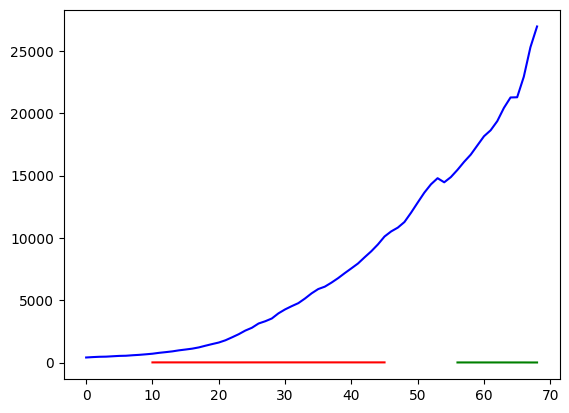

In [26]:
# evaluation
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(dataset['gdp']) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, 0]
    train_plot[lookback:train_size] = model(X_train)[:, -1, 0]
    # shift test predictions for plotting
    test_plot = np.ones_like(dataset['gdp']) * np.nan
    test_plot[train_size+lookback:len(dataset)] = model(X_test)[:, -1, 0]
# plot
plt.plot(dataset['gdp'], c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()